In [1]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
import boto3

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()
#spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).master("local[*]").getOrCreate()

import pandas as pd
import numpy as np
import re
import sys
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

batch_size = 126

### Train the model with only the behavior data

In [2]:
#df_train = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtrain/').sample(0.01)
#df_test = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtest/')
def read_prefix_to_df(prefix):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('fetch-data-puddle')
    prefix_objs = bucket.objects.filter(Prefix=prefix)
    prefix_df = []
    for obj in prefix_objs:
        key = obj.key
        prefix_df.append(key)
        #body = obj.get()['Body'].read()
        #df = pd.DataFrame(body)
        #prefix_df.append(df)
    #return pd.concat(prefix_df)
    return prefix_df
#read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')

In [3]:
def DowloandfileS3(inpt, out):
    bucketname = 'fetch-data-puddle' # replace with your bucket name
    s3 = boto3.resource('s3')
    s3.Bucket(bucketname).download_file(inpt, out)
path_train = read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')[1]
print (path_train)
DowloandfileS3(path_train,'../train.csv')

path_test = read_prefix_to_df('spark/sandbox/mingjun/ORtestCSV')[1]
print (path_test)
DowloandfileS3(path_test,'../test.csv')

path_other = read_prefix_to_df('spark/sandbox/mingjun/ORotherCSV')[1]
print (path_other)
DowloandfileS3(path_other,'../other.csv')

spark/sandbox/mingjun/ORtrainCSV/part-00000-ace753b3-99a7-4b7d-9208-2db591cf18bd-c000.csv
spark/sandbox/mingjun/ORtestCSV/part-00000-4937e451-82b7-4161-986f-daf792106165-c000.csv
spark/sandbox/mingjun/ORotherCSV/part-00000-16c7370a-bcf8-43d3-b71f-722526f462c2-c000.csv


In [13]:
train = pd.read_csv('../train.csv', header=0)
print (train.shape)
#print (train.columns)

test = pd.read_csv('../test.csv', header=0)
print (test.shape)

#other = pd.read_csv('../other.csv', header=0)
#print (other.columns)

(60480, 2287)
(6781, 2287)


In [5]:
print (train.columns)

Index(['user_id', 'offer_id', 'redeem_date', 'cat_brand_sums[0]',
       'cat_brand_sums[1]', 'cat_brand_sums[2]', 'cat_brand_sums[3]',
       'cat_brand_sums[4]', 'cat_brand_sums[5]', 'cat_brand_sums[6]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2287)


In [8]:
X_vars = list(train.columns[3:-1])
#print (X_vars)
x_train, x_test, y_train, y_test = train_test_split(train[X_vars].values, train[list(train.columns)[-1]].values, test_size=0.10, random_state=100)
print (x_train.shape)
print (y_train.shape)
n_columns = x_train.shape[1]

(6102, 2283)
(6102,)


In [9]:
class ORDataset(Dataset):
    ## Define the underline data source
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
        
dataset_train = ORDataset(x_train, y_train)

print ('Number of training set: ', len(dataset_train))
dataLoader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

dataset_test = ORDataset(x_test, y_test)
print ('Number of test data set: ', len(dataset_test))
dataLoader_test = DataLoader(dataset_test, batch_size=len(y_test), shuffle=True, num_workers=1)

Number of training set:  6102
Number of test data set:  679


In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def block(inpt, out):
    return nn.Sequential (
        nn.Linear(inpt, out),
        nn.ReLU()
        )

### Define the model components
class OfferRec(nn.Module):
    def __init__(self, input_size, layers=5):
        super(OfferRec, self).__init__()
        
        ##In this model, I am just using the several fc layers. the last layers is a scalar and through a sigmoid trnsformation.
        dim_layers = []
        
        
        for i in range(layers):
            dim_layers.append(input_size // 2**i )
        print ('Layer distribution: ', dim_layers)
        
        fc_blocks = [block(i, j) for i, j in zip(dim_layers, dim_layers[1:])]
        
        self.mc = nn.Sequential(*fc_blocks)
        
        self.linear = nn.Linear(dim_layers[-1], 1)
    
    def block(self, inpt, out):
        return nn.Sequential (
            nn.Linear(inpt, out),
            nn.ReLU()
            )

    def forward(self, x):
        ## x is the input tensor data
        
        out = self.mc(x)
        out = self.linear(out)
        out = torch.sigmoid(out)

        return out

loss_fn = nn.MSELoss()

model = OfferRec(n_columns).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



Layer distribution:  [2283, 1141, 570, 285, 142]


epoch  10 loss:  4.239002915945093
epoch  20 loss:  2.9697803825502547
epoch  30 loss:  2.263127916560137


Text(0, 0.5, 'MSE')

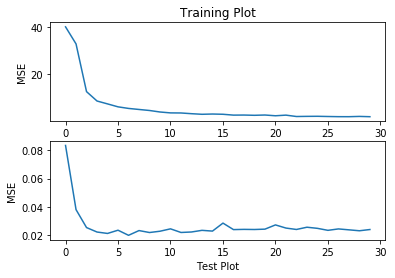

In [11]:
#list_users_train, list_items_train, list_labels_train, list_cats_train, list_manus_train,list_states_train

losses = []
losses_test = []

j= 0
for epoch in range(30):
    model.train()
    total_loss = 0
    for x, y in dataLoader_train:        
        x, y = x.to(device), y.to(device)
        model.zero_grad()

        pred_prob = model(x.float())
        loss = loss_fn(pred_prob, y.float().reshape(x.shape[0],1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    j=j+1
    if j % 10 == 0:
        print ('epoch ' , j, 'loss: ', total_loss)

    losses.append(total_loss)

    with torch.no_grad():
        model.eval()
        for x_t, y_t in dataLoader_test:
            x_t, y_t = x_t.to(device), y_t.to(device)
            pred_prob_test = model(x_t.float())
            loss_test = loss_fn(pred_prob_test, y_t.float().reshape(x_t.shape[0],1))
            loss_test = loss_test.item()
        losses_test.append(loss_test)

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Plot')
plt.ylabel('MSE')

plt.subplot(2, 1, 2)
plt.plot(losses_test)
plt.xlabel('Test Plot')
plt.ylabel('MSE')



In [12]:
#Save ghe model
torch.save(model.state_dict(),'../mode.tp')
the_model = OfferRec(n_columns)
#the_model.load_state_dict(torch.load(PATH))

Layer distribution:  [2283, 1141, 570, 285, 142]


### Performance on the test dataset 

Index(['user_id', 'offer_id', 'redeem_date', 'cat_brand_sums[0]',
       'cat_brand_sums[1]', 'cat_brand_sums[2]', 'cat_brand_sums[3]',
       'cat_brand_sums[4]', 'cat_brand_sums[5]', 'cat_brand_sums[6]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2287)
(6781, 2283)
Layer distribution:  [2283, 1141, 570, 285, 142]
torch.Size([6781, 1])


,prob,target
0,1.665475e-08,0.0
1,7.947796e-08,0.0
2,2.736979e-06,0.0
3,3.036316e-08,0.0
4,2.466297e-04,0.0


   rank  cnt          prob  target
9     9  678  7.843351e-01   498.0
8     8  678  1.223755e-03    11.0
7     7  678  5.136890e-05     2.0
6     6  678  4.751221e-06     1.0
5     5  678  4.478621e-07     1.0
4     4  678  3.856309e-08     0.0
3     3  678  2.623253e-09     2.0
2     2  678  9.386847e-11     0.0
1     1  678  4.523658e-13     2.0
0     0  679  4.641104e-18     5.0


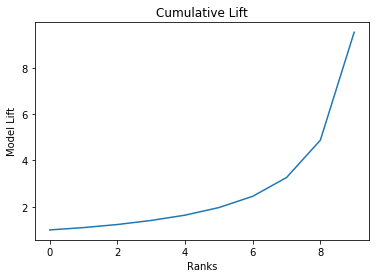

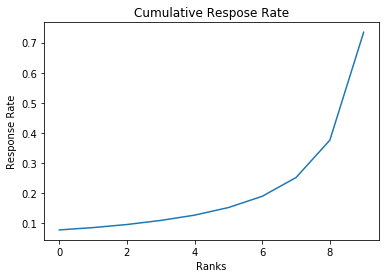

In [14]:
print (test.columns)
print (test.values[:,3:-1].shape)
X_test_tensor = torch.from_numpy(test.values[:,3:-1].astype(float)).float()
y_test_tensor = torch.from_numpy(test['target'].values)

with torch.no_grad():
    model = OfferRec(test.values[:,3:-1].shape[1])
    model.load_state_dict(torch.load('../mode.tp'))
    model.eval()
    pred_prob = model(X_test_tensor)
    print (pred_prob.shape)
    pred = pd.DataFrame(torch.cat((pred_prob, y_test_tensor.float().reshape(-1,1)), 1).numpy(), columns = ['prob', 'target'])
display(pred.head(n=5))

from imp import reload 
import Model
reload(Model)

Lift = Model.ModelLift(c=10)
lift = Lift.calLift(pred, target='target', prob='prob')
Model.Plot(lift)